In [1]:
%matplotlib inline

In [2]:
from matplotlib.pylab import *

In [3]:
# repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
# style.use("results/style_sheet.mplstyle")

rc('figure', figsize=(8, 4))
rc('savefig', bbox='tight')
plt.rcParams.update({'font.size': 16})

import numpy as np
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
import copy
import glob
import numpy as np
import scipy
import copy

In [4]:
param_grid = {
#               'ms': [0],
              'mo': [0.0, 0.5, 0.9],  # momentum
              'width': [4],  # network width
              'wd': [0.0, 1e-4, 5e-4],  # weight decay
              'lr': [0.01, 0.0075, 0.005],  # learning rate
              'bs': [32, 128, 512],  # batch size
              'skip': [True, False], # skip
              'batchnorm': [True, False]  # batchnorm
}
labels = ["$\epsilon$ sharpness", "Pac Bayes", "$||H||_{F}$", "FRN", "Classical Entropy", "Local Entropy","Tr(H)", "Low pass filter"]
all_measures = ["eps_flat", "pac_bayes", "fro_norm", "fim", "shannon_entropy","local_entropy_grad_norm", "eig_trace", "low_pass"]

In [ ]:
# check problematic models
inp = []
for folder in glob.glob("checkpoints/check/resnet/*"):
    try:
        name = glob.glob(f"{folder}/run_ms_*/measures.pkl")[0]
        with open(name, 'rb') as f:
            measures = pickle.load(f)
        if measures['train_loss'] > 0.01:
            print(folder)
    except:
        print(folder)  

In [ ]:
# csv file for ANNA
idx = 0
with open('results/csv_plots.csv', 'w') as f:
    head = "Experiment No,momentum,width,weight_decay," + \
           "learning rate,batch_size,skip connection,batch normalization," + \
           "train_loss,generalization gap," + ",".join(labels) + '\n'
    f.write(head)

# pick a hyper-parameter
for i,grid in enumerate(ParameterGrid(param_grid)):
    name = f"checkpoints/cifar10/resnet/" \
           f"{i}_0_{grid['mo']}_{grid['width']}_{grid['wd']}_" \
           f"{grid['lr']}_{grid['bs']}_{grid['skip']}_{grid['batchnorm']}"
    try:
        with open(f"{name}/run_ms_0/measures.pkl", 'rb') as f:
            measures = pickle.load(f)

        inp = f"{measures['train_loss']}, {-measures['val_acc']+measures['train_acc']},"
        for m in all_measures:
            try:inp += f"{measures[m]},"
            except:inp +=f'nan,'
    except:
        inp = 'nan,'
        for m in all_measures:
            inp += 'nan,' 

    with open('results/csv_plots.csv', 'a') as f:
        inp = f"{i},{grid['mo']},{grid['width']},{grid['wd']},{grid['lr']},{grid['bs']},{grid['skip']},{grid['batchnorm']}," + inp + '\n'
        f.write(inp)

In [ ]:
#scatter plots for anna
idx = 0
# pick a measure
for meas_idx, meas in enumerate(all_measures):
    # pick a hyper-parameter
    for key, value in param_grid.items():
        fig,ax = plt.subplots()
        grid = copy.deepcopy(param_grid)
        del grid[key]
        grid = list(ParameterGrid(grid))

        for i,v in enumerate(value):
            plotting_needs= [[], []]
            # loop over all other set of hyper-parameters
            for params in grid:
                params = copy.deepcopy(params)
                params[key] = v
                name = f"checkpoints/cifar10/resnet/" \
                       f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
                       f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                fol = glob.glob(name)[0]
                try:
                    with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                        measures = pickle.load(f)            
                    if measures["train_loss"] > 0.01:
                        continue
                    plotting_needs[0] += [measures[meas]]
                except:
                    continue
                plotting_needs[1] += [-measures["val_acc"]+measures["train_acc"]]

            ax.scatter(plotting_needs[0], plotting_needs[1], label=f"{key}:{v}")
            ax.set_ylabel("Genralization Gap",fontsize=16)
            ax.set_xlabel(f"{labels[meas_idx]}",fontsize=16)
            ax.set_title(f"{labels[meas_idx]}",fontsize=16)
            ax.legend(fontsize=16)
#             ax.set_ylim([0,0.05])
#             fig.savefig(f"results/{key}_{meas}.png")
#             plt.close()
            plt.show()
            break
        break
    break

In [ ]:
# average the results over seed
# same results as fantastic papers
print("Measure")
for x in param_grid.keys():
    print(x, end=', ')
print(' ')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
idx = 0
# pick a measure
for meas in all_measures:
    print(f"{labels[idx]} & ", end='')

    # pick a hyper-parameter
    for key, value in param_grid.items():

        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        mean_corr = []
        for ms in [0, 1, 2]:
            corr = []
            # loop over all other set of hyper-parameters
            for params in grid:
                flat_measure = []
                gen_gap = []
                # and just vary a single hyper-parameter that we picked
                for v in value:
                    params[key] = v
                    # cifar
                    name = f"checkpoints/cifar10/resnet/" \
                           f"*_{ms}_{params['mo']}_{params['width']}_{params['wd']}_" \
                           f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"
                    fol = glob.glob(name)[0]
                    try:
                        with open(f"{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                            measures = pickle.load(f)
                    except:
                        continue
                    # discard model with less cross-entropy               
                    if measures["train_loss"] > 0.01:
                        continue
                    # record flatness and gen_gap for it
                    try:
                        flat_measure.append(measures[meas])
                    except:
                        continue
                    gen_gap.append(-measures["val_acc"]+measures["train_acc"])

                # compute tau and append (this is inner tau in equation 4 of fantastic)
                # just that our tau is not kendall but pearson
                if len(gen_gap) > 1:
                    c = scipy.stats.kendalltau(flat_measure, gen_gap)[0]
                    if not math.isnan(c):
                        corr.append(c)
            mean_corr.append(np.mean(corr))
        # this is mean over a picked hyper-parameter
        print(f"{np.mean(mean_corr):0.4f} & ", end='')
    idx+=1
    print(' ')

In [ ]:
# same results as fantastic papers
print("Measure")
for x in param_grid.keys():
    print(x, end=', ')
print(' ')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
idx = 0
# pick a measure
for meas in all_measures:
    print(f"{labels[idx]} & ", end='')

    # pick a hyper-parameter
    for key, value in param_grid.items():

        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        # loop over all other set of hyper-parameters
        for params in grid:
            flat_measure = []
            gen_gap = []
            # and just vary a single hyper-parameter that we picked
            for v in value:
                params[key] = v
                for ms in [0,1,2]:
                    # cifar
                    name = f"checkpoints/check/resnet/" \
                           f"*_{ms}_{params['mo']}_{params['width']}_{params['wd']}_" \
                           f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                    fol = glob.glob(name)[0]

                    try:
                        with open(f"{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                            measures = pickle.load(f)
                    except:
                        continue
                    # discard model with less cross-entropy               
                    if measures["train_loss"] > 0.01:
                        continue

                    # record flatness and gen_gap for it
                    try:
                        flat_measure.append(measures[meas])
                    except:
                        continue

                    gen_gap.append(-measures["val_acc"]+measures["train_acc"])

            # compute tau and append (this is inner tau in equation 4 of fantastic)
            # just that our tau is not kendall but pearson
            if len(gen_gap) > 1:
                c = scipy.stats.kendalltau(flat_measure, gen_gap)[0]
                if not math.isnan(c):
                    corr.append(c)
        # this is mean over a picked hyper-parameter
        print(f"{np.mean(corr):0.4f} & ", end='')
    idx+=1
    print(' ')

In [ ]:
print("Empirical order & ", end=' ')
for key, value in param_grid.items():
    print(f"{key} &", end=' ')
print(' ')

for key, value in param_grid.items():

    grid = copy.deepcopy(param_grid)
    del grid[key]

    grid = list(ParameterGrid(grid))
    corr = []
    # loop over all other set of hyper-parameters
    for params in grid:
        gen_gap = []
        hyp = []
        # and just vary a single hyper-parameter that we picked
        for v in value:
            params[f"{key}"] = v
            # cifar
            name = f"checkpoints/cifar10/resnet/" \
                   f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
                   f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

            fol = glob.glob(name)[0]

            try:
                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)
            except:
                continue

            if measures["train_loss"] > 0.01:
                continue
            else:
                # record flatness and hyper-parameter for it
                gen_gap.append((100 - measures["val_acc"]))
                if v is True:
                    hyp.append(1)
                elif v is False:
                    hyp.append(0)
                else:
                    hyp.append(v)

        # compute tau and append (this is inner tau in equation 4 of fantastic)
        # just that our tau is not kendall but pearson
        if len(gen_gap) > 1:
            c = scipy.stats.kendalltau(hyp, gen_gap)[0]
            if not math.isnan(c):
                corr.append(c)
    # this is mean over a picked hyper-parameter
    print(f"{np.mean(corr):0.4f} & ", end='')

In [ ]:
print(f"measure, momentum, weight decay, learning rate, batch size")
idx = 0
for meas in all_measures:
    print(f"{meas} & ", end='')
    for key, value in param_grid.items():
        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        for params in grid:
            flat_measure = []
            hyper_param = []
            for v in value:
                params[f"{key}"] = v
                #mnist
#                 name = f"checkpoints/mnist/lenet/" \
#                        f"*_0_{params['mo']}_{params['wd']}" \
#                        f"_{params['lr']}_{params['bs']}_{False}"
                # cifar
#                 name = f"checkpoints/cifar10/resnet/" \
#                        f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
#                        f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                fol = glob.glob(name)[0]

                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)

                if np.nan in list(measures.values()):
                    continue

                if measures['train_loss'] > 0.01:
                    continue
                else:
                    flat_measure.append(measures[meas])
                    if v is True:
                        hyper_param.append(1)
                    elif v is False:
                        hyper_param.append(0)
                    else:
                        hyper_param.append(v)
            if len(hyper_param)>1:
                corr.append(scipy.stats.pearsonr(hyper_param, flat_measure)[0])

        print(f"{np.mean(corr):0.3f} & ", end='')
    print('')

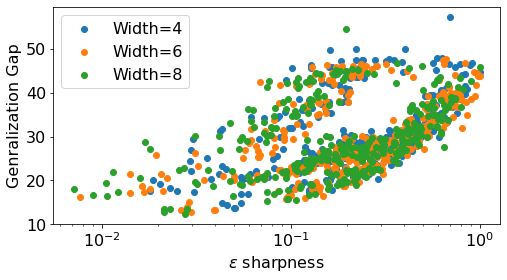

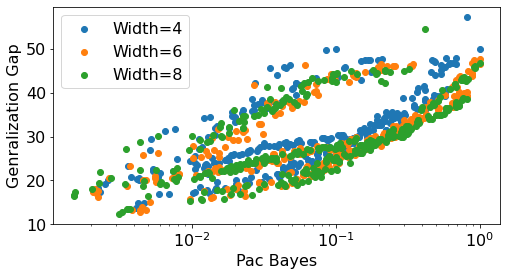

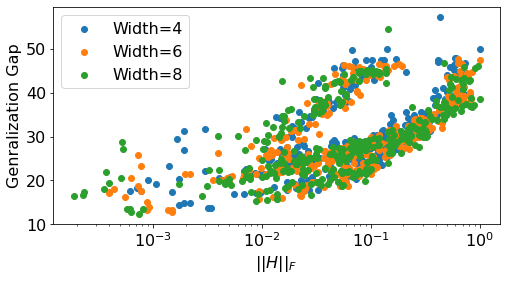

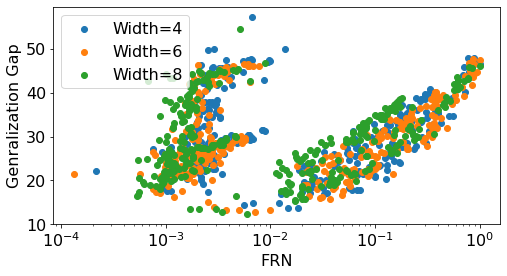

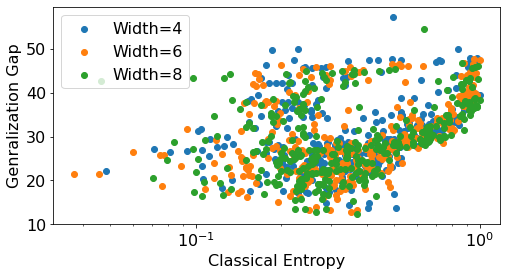

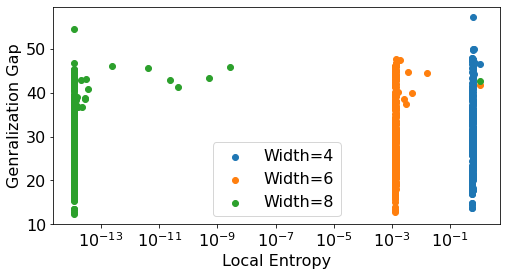

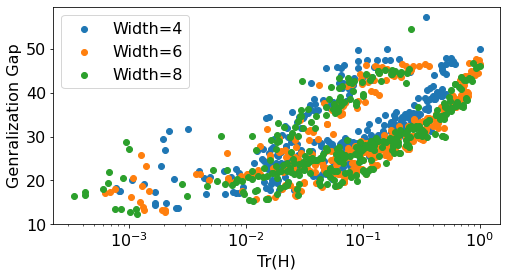

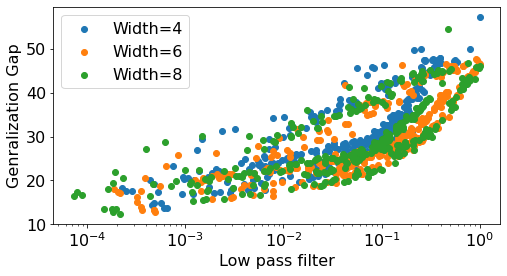

In [7]:
#scatter plots for anna
idx = 0
# pick a measure
for meas_idx, meas in enumerate(all_measures):
    fig,ax = plt.subplots()
    for idx, width in enumerate([4, 6, 8]):
        plotting_needs = [[], []]
        for params in list(ParameterGrid(param_grid)):
            name = f"checkpoints/cifar10/resnet/" \
                   f"*_0_{params['mo']}_{width}_{params['wd']}_" \
                   f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

            fol = glob.glob(name)[0]
            try:
                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)            
                if measures["train_loss"] > 0.01:
                    continue
                if not np.isnan(measures[meas]):
                    plotting_needs[0] += [measures[meas]]
                else:
                    continue
            except:
                continue
            plotting_needs[1] += [-measures["val_acc"]+measures["train_acc"]]
        ax.scatter([x / np.max(plotting_needs[0]) for x in plotting_needs[0]], plotting_needs[1], label = f"Width={width}")
    ax.set_ylabel("Genralization Gap",fontsize=16)
    ax.set_xlabel(f"{labels[meas_idx]}",fontsize=16)
    ax.set_xscale('log')
    ax.legend(fontsize=16)
    fig.savefig(f"results/scatter/{labels[meas_idx]}.png")
#     plt.close()